In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
bit_data=pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

In the above step a colum which "date" is and converted "Timestamp" columns to date form.

In [3]:
data.shape

(2627,)

In [4]:
data.isnull().sum()

0

In [6]:
data.head()

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

<h1> RNN </h1>

Separating last 50 rows as test set

In [7]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

feature scalling (set values between 0-1) to avoid domination of high values

In [8]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

choosing each 50 data as x-train and 51th as y-train

In [9]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2527, 50, 1)
y_train shape=  (2527,)


In [10]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
40/40 [==============================] - 23s 427ms/step - loss: 0.0053
Epoch 2/100
40/40 [==============================] - 17s 432ms/step - loss: 0.0021
Epoch 3/100
40/40 [==============================] - 18s 437ms/step - loss: 0.0021
Epoch 4/100
40/40 [==============================] - 18s 442ms/step - loss: 0.0014
Epoch 5/100
40/40 [==============================] - 18s 454ms/step - loss: 0.0013
Epoch 6/100
40/40 [==============================] - 18s 453ms/step - loss: 0.0011
Epoch 7/100
40/40 [==============================] - 19s 475ms/step - loss: 9.3226e-04
Epoch 8/100
40/40 [==============================] - 19s 465ms/step - loss: 9.3228e-04
Epoch 9/100
40/40 [==============================] - 18s 454ms/step - loss: 0.0011
Epoch 10/100
40/40 [==============================] - 18s 454ms/step - loss: 7.0764e-04
Epoch 11/100
40/40 [==============================] - 19s 467ms/step - loss: 6.9099e-04
Epoch 12/100
40/40 [==============================] - 18s 462ms/step 

40/40 [==============================] - 13s 321ms/step - loss: 2.3586e-04
Epoch 95/100
40/40 [==============================] - 13s 325ms/step - loss: 2.6800e-04
Epoch 96/100
40/40 [==============================] - 13s 324ms/step - loss: 3.9753e-04
Epoch 97/100
40/40 [==============================] - 13s 320ms/step - loss: 3.2022e-04
Epoch 98/100
40/40 [==============================] - 13s 332ms/step - loss: 2.9220e-04
Epoch 99/100
40/40 [==============================] - 13s 315ms/step - loss: 4.7608e-04
Epoch 100/100
40/40 [==============================] - 13s 317ms/step - loss: 3.8201e-04


preparing test data for prediction

In [11]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [12]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [13]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

2/2 [==============================] - 3s 26ms/step


In [14]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

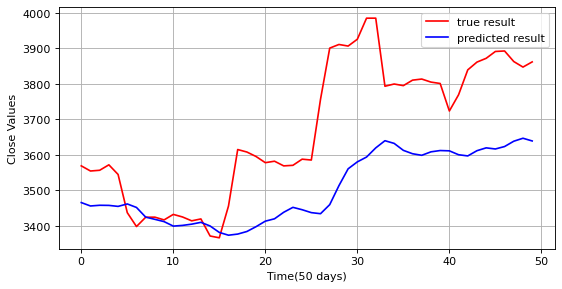

In [15]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

Now applying LTSM

In [16]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0147
Epoch 2/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0011
Epoch 3/100
79/79 [==============================] - 1s 10ms/step - loss: 6.1903e-04
Epoch 4/100
79/79 [==============================] - 1s 9ms/step - loss: 5.4692e-04
Epoch 5/100
79/79 [==============================] - 1s 8ms/step - loss: 5.3787e-04
Epoch 6/100
79/79 [==============================] - 1s 8ms/step - loss: 4.8889e-04
Epoch 7/100
79/79 [==============================] - 1s 8ms/step - loss: 4.5617e-04
Epoch 8/100
79/79 [==============================] - 1s 8ms/step - loss: 4.3017e-04
Epoch 9/100
79/79 [==============================] - 1s 8ms/step - loss: 3.8370e-04
Epoch 10/100
79/79 [==============================] - 1s 8ms/step - loss: 3.5111e-04
Epoch 11/100
79/79 [==============================] - 1s 8ms/step - loss: 3.1892e-04
Epoch 12/100
79/79 [==============================] - 1s 8ms/step - loss: 3.2436e

79/79 [==============================] - 1s 9ms/step - loss: 1.0004e-04
Epoch 98/100
79/79 [==============================] - 1s 9ms/step - loss: 9.9003e-05
Epoch 99/100
79/79 [==============================] - 1s 9ms/step - loss: 9.6151e-05
Epoch 100/100
79/79 [==============================] - 1s 9ms/step - loss: 9.7152e-05


In [17]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [18]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [19]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

2/2 [==============================] - 0s 3ms/step


In [20]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

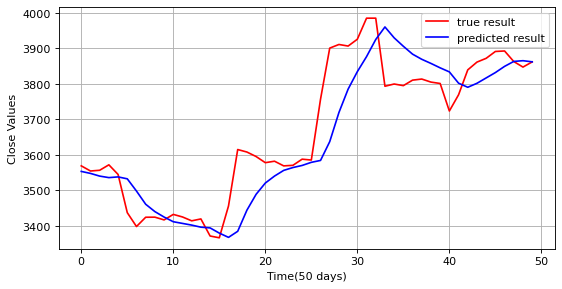

In [20]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()
